# Example for the use of the $O-C$ code used for Csörnyei et al. 2021

#### The first version of the analysis code is available in an importable file

In [1]:
from OCcalculator import O_Ccalculator as OCC

D:\Anaconda3\lib\site-packages\pyfits\__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


### First the data directory and the coordinates of the star have to be specified (the latter are need to be known for the heliocentric correction applied on the Julian-dates)

In [2]:
name = 'IR_Cep'
indir = './IR_Cep_test/'


ra = 329.46633 
dec = +61.01886

### The code first finds and processes all the files starting with "Phot_" containing the ligthcurves. The files need to contain two columns: the JD / HJD / MJD of the observations and the lightcurve, with a column name of "V" (regardless of what band the brightness values were actually measured in)

In [3]:
surveys = OCC.process_photometry(indir, ra, dec)
# The 'surveys' will be a list of strings containing the names of the photometry sources considered. The script creates
# a 'feldolg_' file for every photometry file, which contains only the HJD and the corresponding magnitudes in a machine
# readable, standardized format. 

In [7]:
# As a next step these files are needed to be imported to Period04, where the Fourier fitting of the lightcurves can be
# carried out. Once it is done, a .per file has to be saved for every "feldolg_" files, which will contain the frequencies,
# amplitudes and phases of the light curve fits. The naming scheme of the files should be "period_" then the name of the
# photometry file without the "Phot_" part.

In [9]:
# If several outliers are present in the data, those can be cut off with this script, which will leave only the spicified
# brightness range untouched

OCC.apply_filter(indir,'feldolg_asas_sn_g.dat',[8.03,8.61])

### After this step, the lightcurves can be fit. The next script cuts the dataset into pieces covering a specified time length, then folds the corresponding light curves, fits them with the models obtained through the Fourier fitting, then calculates the epoch of  the zeropoint on the rising edge or that of the maximum (this can be specified). It also applies a bootstrapping on the fitting to obtain uncertainty values along with the best fit values.

period_AAVSO.per
17 4
768 9


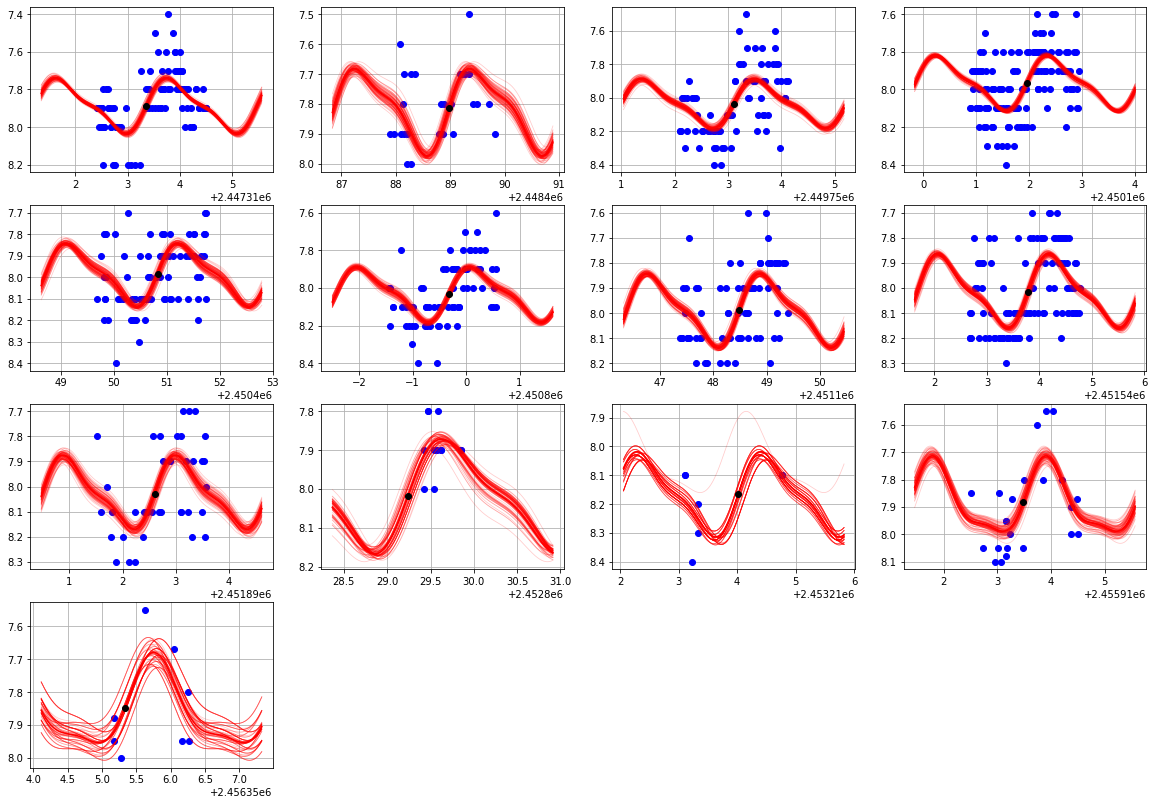

13
period_ASASSN-g.per
2 0
533 0


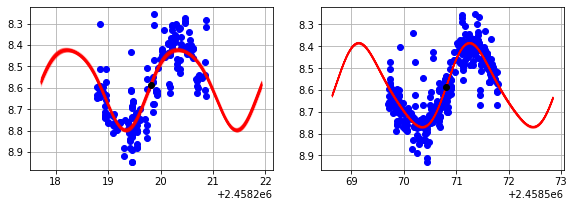

2
period_ASASSN-V.per
5 0
565 0


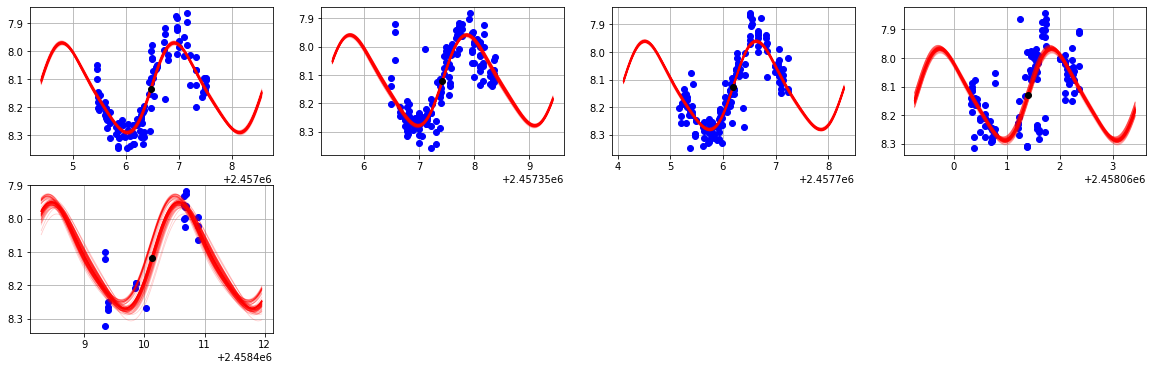

5
period_Berdnikov2008.per
6 0
168 0


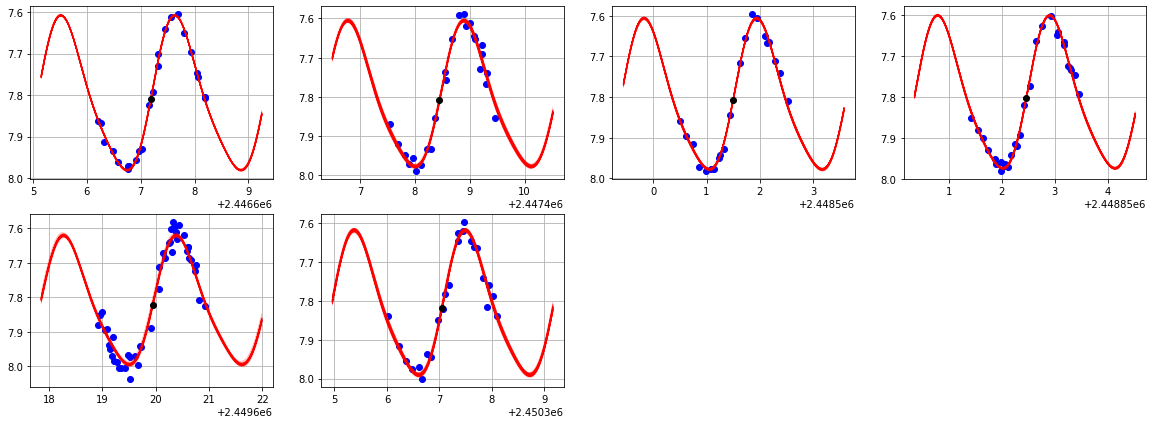

6
period_Harvard.per
87 6
7696 20


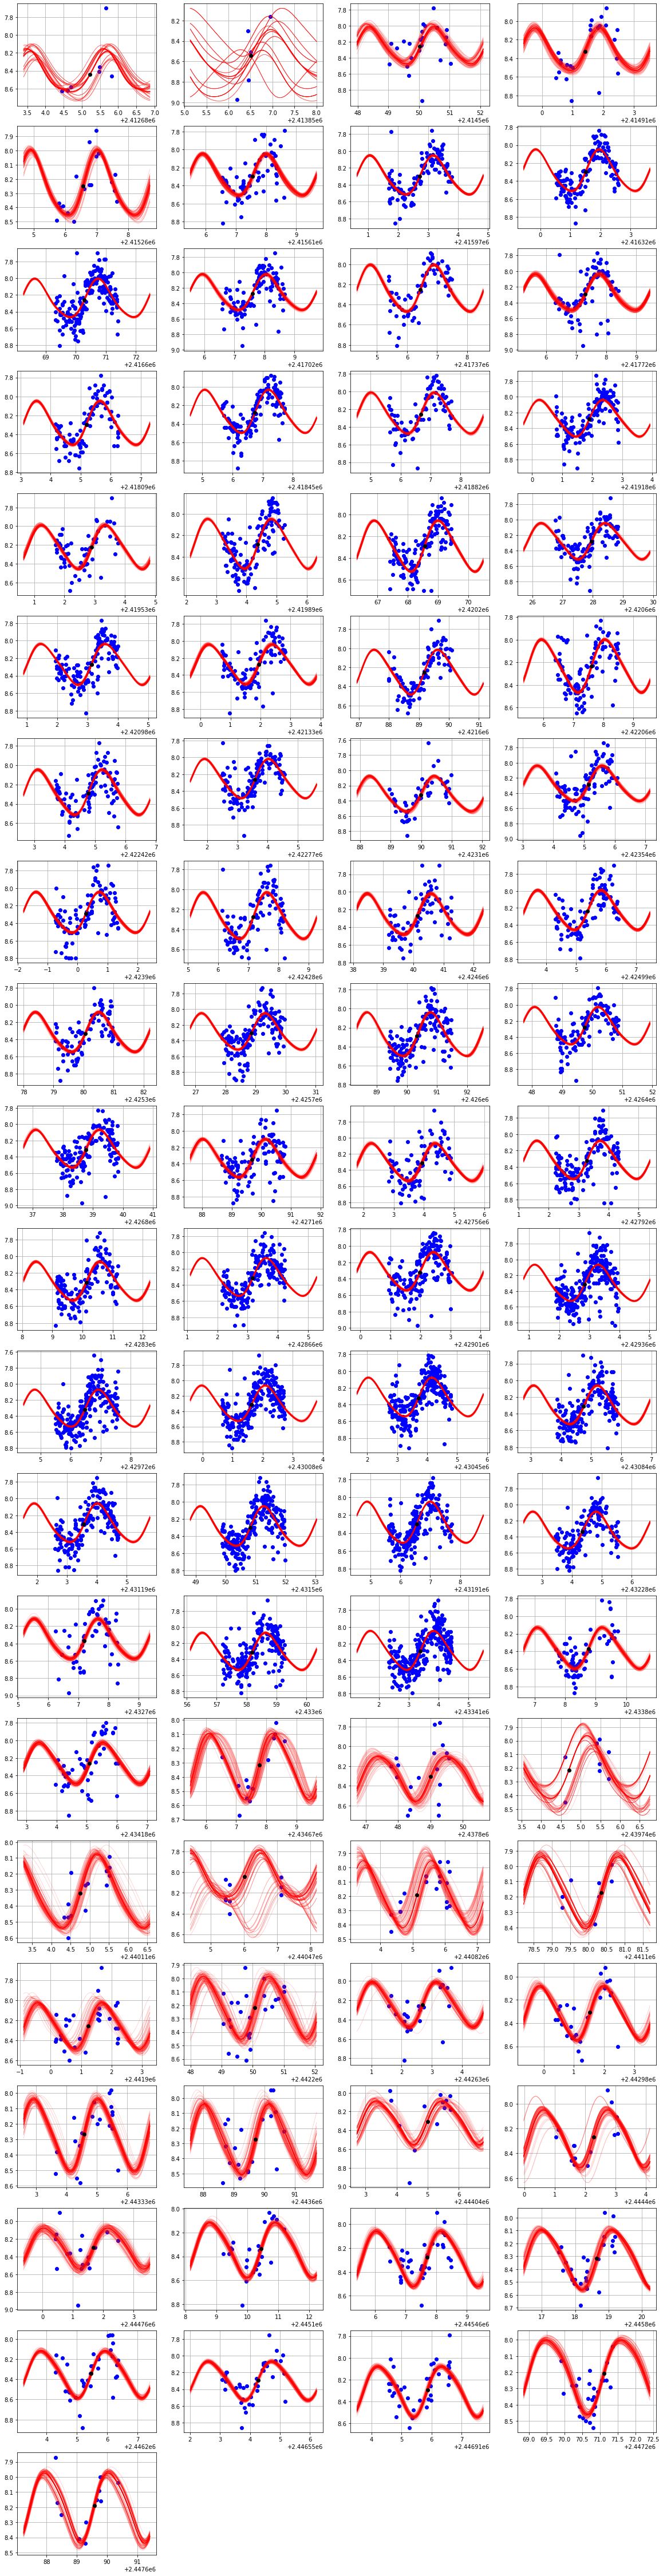

81
period_Hipp.per
4 1
130 3


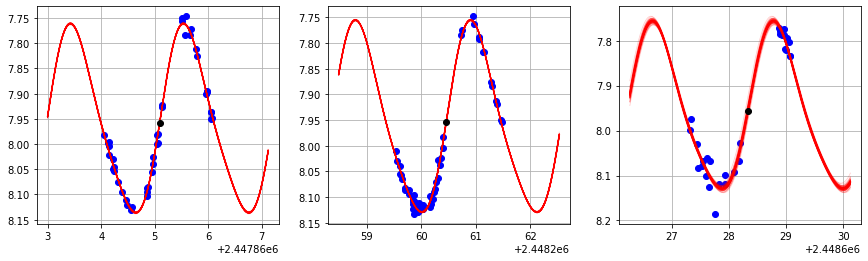

3
period_KWS.per
Infinite loop break 

7 0
915 0


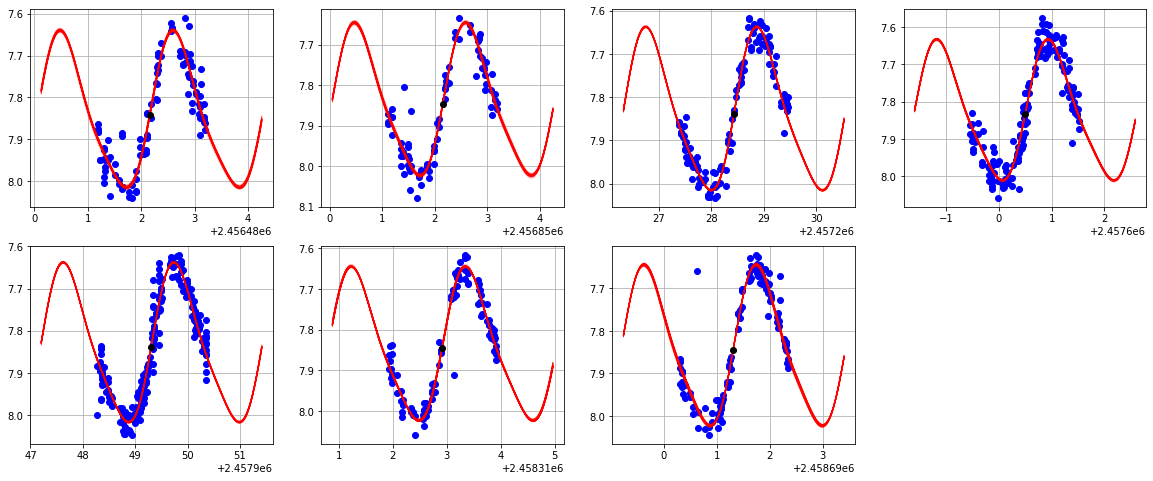

7
period_Szabados1977.per
1 0
21 0


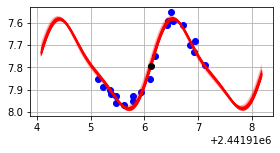

1
period_Wachmann1976.per
3 1
55 4


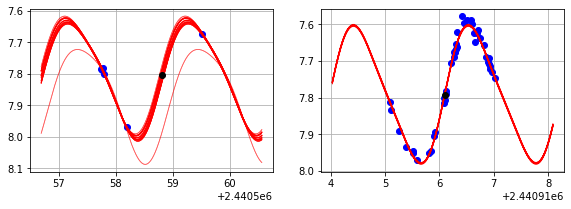

2


In [12]:
fs, nm = OCC.find_epochs(indir,surveys,350,5,ep_method='Zerop') 
# or ep_method='Maximum'. The first number specifies the length of the
# time bins used for the folding, while the second number specifies the
# minimal amount of datapoints in these bins

### The black dots represent the fitted position of either the zeropoint or the maximum. The resulting HJD values, the brightness values of the fitted positions and the time uncertainties are stored in the "peaks_" files

In [ ]:
# The next step is to calculate the O-C files. This is done by an external program which was written in C for the moment. As a 
# first step one must define the period value of the Cepheid, which is done through importing a .per file. This period value
# is then passed to the O-C calculator script, which will then run through the individual "peaks_" files. For the calculation
# of the O-C epochs one must define a reference epoch as well, which can be arbitrarily set. 

In [39]:
F_all, A_all, PH_all = OCC.load_P04_file(indir, 'period_Berdnikov2008.per')
refepoch = 2449939.121

freqv = 1 / 2.11407

OCC.calc_OC(indir, refepoch, freqv, surveys = surveys)
OCC.calc_OC(indir, refepoch, freqv, fn = 'Data_Szabados1991.dat')
OCC.calc_OC(indir, refepoch, freqv, fn = 'Data_Klawitter1971.dat')

In [40]:
# Once this step is done, the outliers are removed based on their estimated uncertainties: if the error of an O-C point exceeds
# the period value, or exactly 0 (which means a failure in the calculation) then those points are discarded

OCC.remove_errors(indir, surveys, 1 / freqv)

['OC_Klawitter1971_comp.dat', 'OC_Szabados1991_comp.dat']


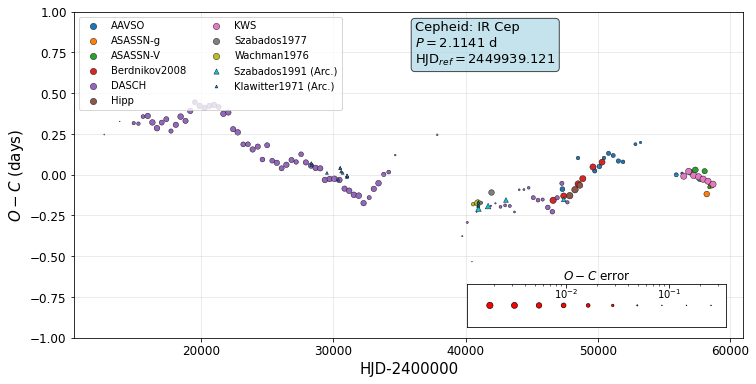

In [5]:
# The only remaining thing to do is to plot the O-C diagram. This can be done with the following script, just by specifying a 
# few values.

y_limits=[-1,1] # The limits on the y axis for the plot

P = 1 / freqv

o_data = ['OC_Szabados1991_comp.dat', 'OC_Klawitter1971_comp.dat'] # List of arcihival datafiles to plot
W_offset = -0.41 # The offset between the archival and new analysis data. Here this value is not important, since the
                 # openly available data cover a wider temporal range than the previous analysises do. However, in some
                 # cases the archival datapoint do go back farther into the past, in this the diagrams have to be matched
                 # by observations at relatively the same epochs.
OCC.create_OC_plot('HJD', surveys, P, name, y_limits, indir, refepoch, offs = W_offset, old_data = o_data, save=False,
               trunc_date=True, onec = False)  

['OC_Klawitter1971_comp.dat', 'OC_Szabados1991_comp.dat']
['OC_Klawitter1971_comp.dat', 'OC_Szabados1991_comp.dat']
[ 5.51692459e-10 -2.69850714e-03  3.29974030e+03]


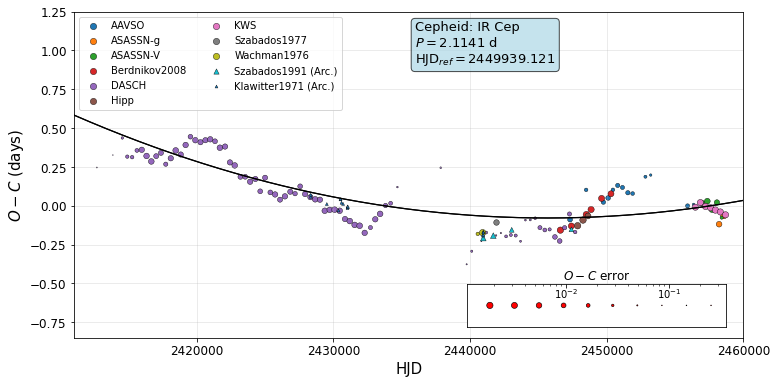

In [6]:
# Also a fit can be applied on these plots. For the moment the most complex fit can be the parabolic + sinusoidal signal
# fit, however since this example is obviously more complex, we only fit the secular period change, or the long term
# evolutionary trend
import numpy
ranges = numpy.array(([2411000,2460000]))  # The x range of the plot
types = "k-"  # Type of the fit line
text_coords = [2400000,0.6]  # Position of the text (the exact fitting formula, turned off for the example)

modif = OCC.setup_modif_dict(ranges,types,text_coords)
y_limits = [-0.85,1.25]
fit_pm = OCC.create_OC_with_fit('HJD', surveys, P, name, y_limits, indir, refepoch, order=2, old_data = o_data, txt='OFF',
                               modif = modif, offs = W_offset)

In [ ]:
# And also the residual plot can be calculated by passing the fit_pm fitting parameters for the next script.

['OC_Klawitter1971_comp.dat', 'OC_Szabados1991_comp.dat']


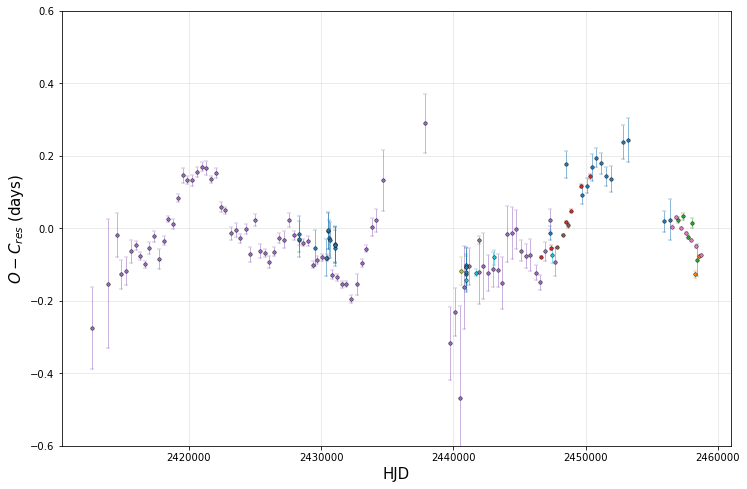

In [8]:
y_limits = [-0.6,0.6]
OCC.create_OC_residual_plot('HJD', surveys, P, name, y_limits, indir, fit_pm, old_data = o_data, offs = W_offset)